# DeepHit for Single Event

In this notebook we show an example of how we can fit a [DeepHit](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit) model when we only have *one* event type.

If you are interested in **competing risks**, see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/deephit_competing_risks.ipynb) instead.

For a more verbose introduction to `pycox` see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In [404]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
import pandas as pd

In [405]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [406]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [407]:

df_ = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')
selected = ["RNF114", "OR52A4", "ARL6", "OR4C3", "HIGD1A", "MIR1284", "RNU4ATAC7P", 'OS_MONTHS', 'OS_STATUS']
selected = ["RNF114",     "OR52A4",     "ARL6",       "OR4C3",      "HIGD1A",     "MIR1284",    "RNU4ATAC7P", 
            "MIR4274",    "MAL",        "PRUNE2",     "RN7SL338P",  "RCAN3",      "RNA5SP135",  "VAMP1",
            "LIN54",      "E2F1",       "ZNF215",     "MUC5B",      "SLC47A2",    "TMEM128",
            'OS_MONTHS', 'OS_STATUS']
df_ = df_[selected]
df_test = df_test[selected]
df_.rename(columns={'OS_MONTHS': 'duration', "OS_STATUS": 'event'}, inplace=True)
df_test.rename(columns={'OS_MONTHS': 'duration', "OS_STATUS": 'event'}, inplace=True)

df_train, df_val = train_test_split(df_, test_size=0.25, random_state=0)

In [408]:
df_train.columns

Index(['RNF114', 'OR52A4', 'ARL6', 'OR4C3', 'HIGD1A', 'MIR1284', 'RNU4ATAC7P',
       'MIR4274', 'MAL', 'PRUNE2', 'RN7SL338P', 'RCAN3', 'RNA5SP135', 'VAMP1',
       'LIN54', 'E2F1', 'ZNF215', 'MUC5B', 'SLC47A2', 'TMEM128', 'duration',
       'event'],
      dtype='object')

In [409]:
df_test['duration'].dtype

dtype('float64')

## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

We like using the `sklearn_pandas.DataFrameMapper` to make feature mappers.

In [410]:
cols_standardize = filtered_list = [x for x in df_train.columns if x not in ['duration', 'event']]
cols_leave = []

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [411]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
In this case `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

DeepHit is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

In [412]:
num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [413]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `num_nodes` output nodes.
We also have batch normalization and dropout between the layers.

In [414]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

If you instead want to build this network with `torch` you can uncomment the following code.
It is essentially equivalent to the `MLPVanilla`, but without the `torch.nn.init.kaiming_normal_` weight initialization.

In [415]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, out_features)
# )

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

We also set `duration_index` which connects the output nodes of the network the the discretization times. This is only useful for prediction and does not affect the training procedure.

DeepHit has a loss that is a combination of a negative log-likelihood and a ranking loss. `alpha` is a parameter that controls the linear combination between the two, and `sigma` is a parameter used by the ranking loss. `alpha = 1` give a loss only containing the negative log-likelihood and `alpha = 0` give a pure ranking loss. Note that this is different than the original paper.

In [416]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

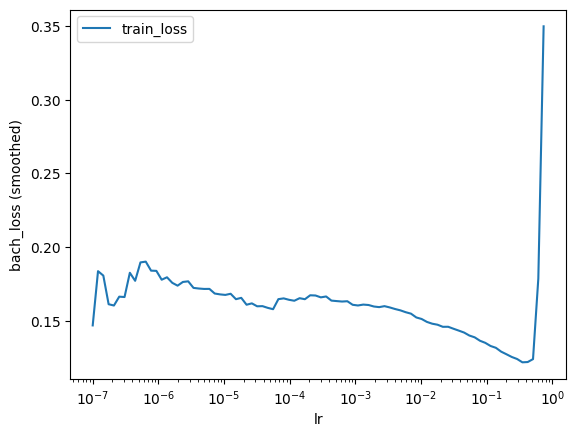

In [417]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [418]:
lr_finder.get_best_lr()

0.035111917342151515

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [419]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [420]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.1465,	val_loss: 0.1445
1:	[0s / 0s],		train_loss: 0.1310,	val_loss: 0.1372
2:	[0s / 0s],		train_loss: 0.1180,	val_loss: 0.1344
3:	[0s / 0s],		train_loss: 0.1104,	val_loss: 0.1327
4:	[0s / 0s],		train_loss: 0.0914,	val_loss: 0.1324
5:	[0s / 0s],		train_loss: 0.0986,	val_loss: 0.1342
6:	[0s / 0s],		train_loss: 0.0889,	val_loss: 0.1392
7:	[0s / 0s],		train_loss: 0.0849,	val_loss: 0.1464
8:	[0s / 0s],		train_loss: 0.0949,	val_loss: 0.1737
9:	[0s / 0s],		train_loss: 0.0662,	val_loss: 0.1863
10:	[0s / 0s],		train_loss: 0.0668,	val_loss: 0.1968
11:	[0s / 0s],		train_loss: 0.0784,	val_loss: 0.1845
12:	[0s / 0s],		train_loss: 0.0717,	val_loss: 0.1593
13:	[0s / 0s],		train_loss: 0.0626,	val_loss: 0.1458
14:	[0s / 0s],		train_loss: 0.0552,	val_loss: 0.1368


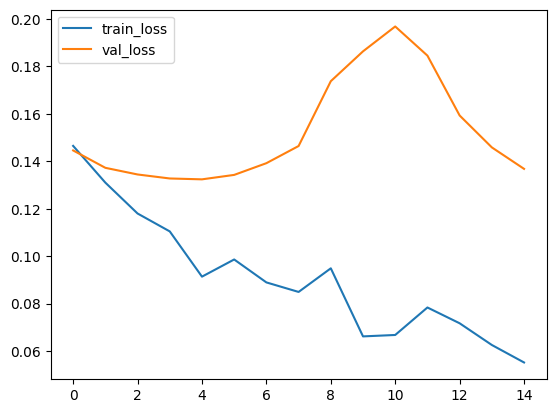

In [421]:
_ = log.plot()

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [422]:
surv = model.predict_surv_df(x_test)

We can plot the survival estimates for the first 5 individuals.
Note that the time scale is correct because we have set `model.duration_index` to be the grid points.
We have, however, only defined the survival estimates at the 10 times in our discretization grid, so, the survival estimates is a step function

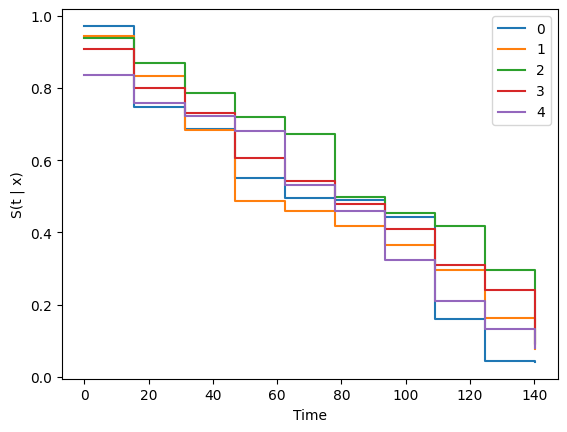

In [423]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

It is, therefore, often beneficial to interpolate the survival estimates, see [this paper](https://arxiv.org/abs/1910.06724) for a discussion.
Linear interpolation (constant density interpolation) can be performed with the `interpolate` method. We also need to choose how many points we want to replace each grid point with. Her we will use 10.

In [424]:
surv = model.interpolate(10).predict_surv_df(x_test)
model.predict_surv(x_test).shape


(133, 10)

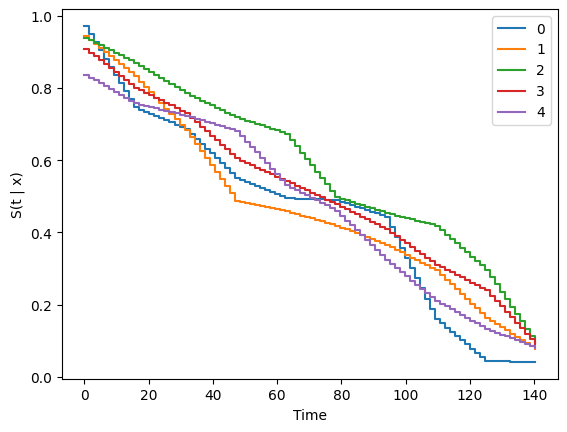

In [425]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [426]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/Users/haily/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [427]:
ev.concordance_td('antolini')

0.419953596287703

Text(0.5, 1.0, 'Risk Scores of Samples')

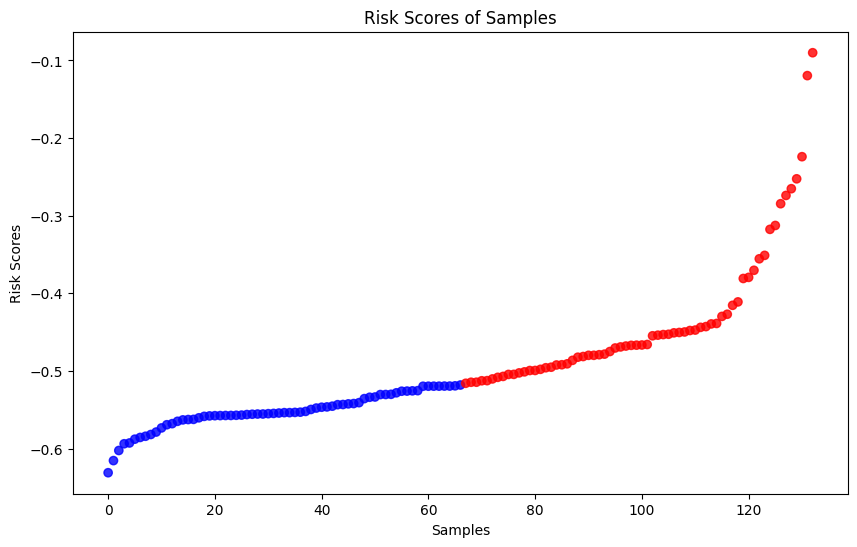

In [428]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Assuming predictions is the output of model.predict_surv(x_test)
predictions = model.predict_surv(x_test)

# print('predictions: ', predictions)

# Step 1: Calculate Risk Scores
risk_scores = -np.median(predictions, axis=1)  # Taking median of the survival probabilities as risk scores
# print('risk_scores: ', risk_scores)

# Step 2: Determine Threshold
threshold = np.median(risk_scores)

# Step 3: Assign Group Labels
risk_groups = np.where(risk_scores > threshold, "High Risk", "Low Risk")

df_test['risk_groups'] = risk_groups
# print('risk_groups: ', risk_groups)

# Step 4: Display distribution of risk groups
# print(pd.Series(risk_groups).value_counts())

# Step 5: Plot risk scores against samples using a scatter plot
sorted_indices = np.argsort(risk_scores)
sorted_risk_scores = risk_scores[sorted_indices]
sorted_risk_groups = risk_groups[sorted_indices]

# Map risk groups to colors
colors = np.where(sorted_risk_groups == 'High Risk', 'r', 'b')

plt.figure(figsize=(10, 6))
plt.scatter(range(len(risk_scores)), sorted_risk_scores, c=colors, alpha=0.8)
plt.xlabel('Samples')
plt.ylabel('Risk Scores')
plt.title('Risk Scores of Samples')

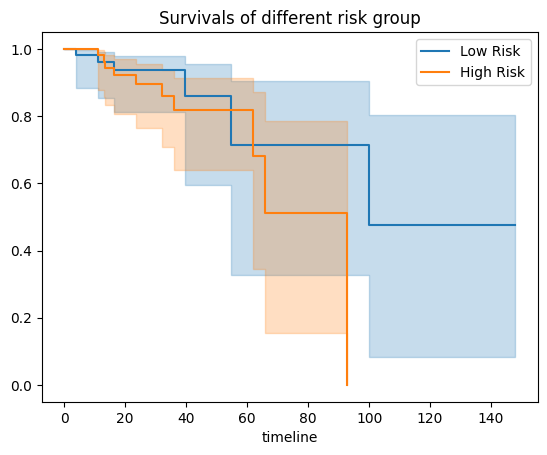

In [429]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

high_risk = df_test["risk_groups"] == 'High Risk'

ax = plt.subplot(111)

T = df_test['duration']
E = df_test['event']

t = np.linspace(0, 140, 51)

kmf.fit(T[~high_risk], event_observed=E[~high_risk],label="Low Risk")
ax = kmf.plot_survival_function(ax=ax)

kmf.fit(T[high_risk], event_observed=E[high_risk], timeline=t, label="High Risk")
ax = kmf.plot_survival_function(ax=ax)

plt.title("Survivals of different risk group");